In [1]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set device to GPU if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class HeteroskedasticMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(HeteroskedasticMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        z = self.fc3(x)
        # Get mu and log_sigma from the last layer
        mu, log_sigma = z[:, 0], z[:, 1]
        return mu, log_sigma

In [42]:
# Create model

model = HeteroskedasticMLP(6, 100)

# Move model to device

model = model.to(device)

# Define loss function

def heteroskedastic_loss(y, mu, log_sigma):
    sigma = torch.exp(log_sigma)
    ll = dist.Normal(mu.ravel(), sigma.ravel()).log_prob(y.ravel())
    return -ll.mean()

In [25]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

unpickled_df = pd.read_csv("/home/agarwal.aditi/openaq_delhi/aq_v2_fourrier_ts.csv")  


df2 = unpickled_df.drop(['Unnamed: 0','station'], axis=1)
df2 = df2[df2['PM2.5']!= 'None']




scaler = StandardScaler().fit(df2.iloc[:,:-1])
X_scaled = scaler.transform(df2.iloc[:,:-1])
X_scaled

array([[-1.71177383, -1.71175727,  1.80059788,  0.02133276, -0.3985605 ,
         0.99169336],
       [-1.71138132, -1.71136476,  1.53594056,  0.02133276, -0.3985605 ,
         0.99169336],
       [-1.71098881, -1.71097225,  0.91529883,  0.02133276, -0.3985605 ,
         0.99169336],
       ...,
       [ 1.73445571,  1.73450574,  0.83114402, -0.69418858,  0.64853646,
         1.49096697],
       [ 1.73484822,  1.73489826,  1.78744869, -0.69418858,  0.64853646,
         1.49096697],
       [ 1.73524073,  1.73520573,  1.90698677, -0.69418858,  0.64853646,
         1.49096697]])

In [26]:
pd.DataFrame(X_scaled).describe()

,0,1,2,3,4,5
count,3.171690e+05,3.171690e+05,3.171690e+05,3.171690e+05,3.171690e+05,3.171690e+05
mean,4.038930e-15,-1.020199e-14,2.419487e-16,-9.429904e-14,-2.299093e-13,-5.107805e-18
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.711774e+00,-1.711757e+00,-1.187735e+00,-2.015051e+00,-2.939606e+00,-1.504675e+00
25%,-8.698419e-01,-8.698172e-01,-7.034859e-01,-8.160074e-01,-7.135649e-01,-1.005401e+00
50%,-1.299462e-02,-1.296156e-02,-3.014793e-01,2.133276e-02,2.476964e-02,-6.853877e-03
75%,8.760384e-01,8.760801e-01,4.157492e-01,6.931141e-01,7.350033e-01,9.916934e-01
max,1.735241e+00,1.735206e+00,1.059741e+01,2.229318e+00,1.628837e+00,1.490967e+00


In [14]:
df2

,From Date,To Date,PM2.5,latitude,longitude,day of week,hour of day
0,1.640995e+09,1.640999e+09,250.10,28.639645,77.146263,5,0
1,1.640999e+09,1.641002e+09,227.96,28.639645,77.146263,5,1
2,1.641002e+09,1.641006e+09,176.04,28.639645,77.146263,5,2
3,1.641006e+09,1.641010e+09,182.72,28.639645,77.146263,5,3
4,1.641010e+09,1.641013e+09,196.83,28.639645,77.146263,5,4
...,...,...,...,...,...,...,...
317164,1.672596e+09,1.672600e+09,66.00,28.580280,77.233829,6,18
317165,1.672600e+09,1.672603e+09,112.00,28.580280,77.233829,6,19
317166,1.672603e+09,1.672607e+09,169.00,28.580280,77.233829,6,20
317167,1.672607e+09,1.672610e+09,249.00,28.580280,77.233829,6,21


In [27]:
import pandas as pd
import numpy as np


# Define function for train-test split with chunks of data removed
def time_series_train_test_split(data, test_chunk_sizes, val_chunk_sizes, random_seed=None):
    """
    Perform train-test split for time series data with chunks of data removed at different time points.

    Args:
        data (pd.DataFrame): Input time series data.
        test_chunk_sizes (list): List of chunk sizes (number of consecutive days) for test data.
        val_chunk_sizes (list): List of chunk sizes (number of consecutive days) for validation data.
        random_seed (int): Random seed for reproducibility. Defaults to None.

    Returns:
        train_data (pd.DataFrame): Train data.
        test_data (pd.DataFrame): Test data.
        val_data (pd.DataFrame): Validation data.
    """
    # Shuffle chunk sizes randomly
    if random_seed is not None:
        np.random.seed(random_seed)
    np.random.shuffle(test_chunk_sizes)
    np.random.shuffle(val_chunk_sizes)

    # Perform train-test split with chunks of data removed
    train_data = data.copy()
    test_data = pd.DataFrame(columns=data.columns)
    val_data = pd.DataFrame(columns=data.columns)

    for chunk_size in test_chunk_sizes:
        if len(train_data) >= chunk_size:
            test_idx = np.random.randint(0, len(train_data) - chunk_size + 1)
            test_data = pd.concat([test_data, train_data.iloc[test_idx:test_idx+chunk_size]])
            train_data = train_data.drop(train_data.index[test_idx:test_idx+chunk_size])

    for chunk_size in val_chunk_sizes:
        if len(train_data) >= chunk_size:
            val_idx = np.random.randint(0, len(train_data) - chunk_size + 1)
            val_data = pd.concat([val_data, train_data.iloc[val_idx:val_idx+chunk_size]])
            train_data = train_data.drop(train_data.index[val_idx:val_idx+chunk_size])

    return train_data, test_data, val_data




In [28]:


import random
test_chunk_sizes = []
val_chunk_sizes = []
while sum(test_chunk_sizes) < 15000:
    test_chunk_sizes.append(random.randint(1,7))

while sum(val_chunk_sizes) < 15000:
    val_chunk_sizes.append(random.randint(1,7))

train_data, test_data, val_data =  time_series_train_test_split(pd.DataFrame(X_scaled), test_chunk_sizes, val_chunk_sizes, random_seed=42)

In [29]:
X_train = np.array(train_data)
y_train = df2['PM2.5'][train_data.index]
X_test = np.array(test_data)
y_test = df2['PM2.5'][test_data.index]
X_val = np.array(val_data)
y_val = df2['PM2.5'][val_data.index]


In [30]:
import numpy as np
train = torch.tensor(X_train.astype(np.float32)).to(device)
train_target = torch.tensor(y_train.values.astype(np.float32)).to(device)

test = torch.tensor(X_test.astype(np.float32)).to(device)
test_target = torch.tensor(y_test.values.astype(np.float32)).to(device)

In [31]:
with torch.no_grad():
    mu, log_sigma = model(train)
    loss = heteroskedastic_loss(train_target, mu, log_sigma)
    print(loss)

tensor(5.5167, device='cuda:0')


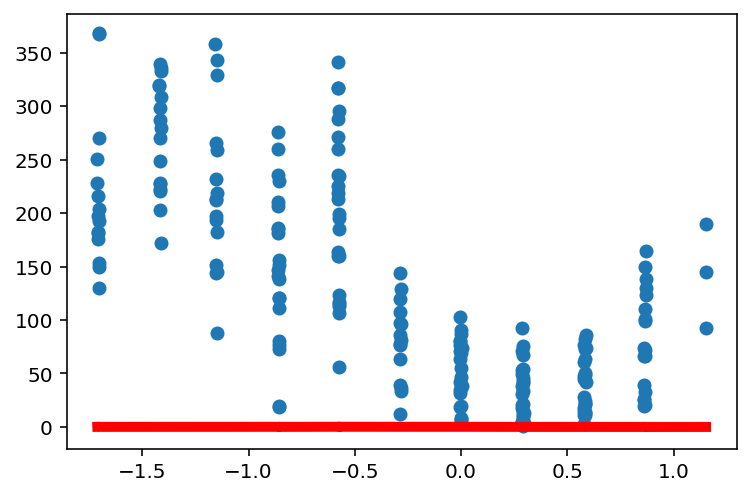

In [34]:
with torch.no_grad():
    mu, log_sigma = model(train[:200])
    sigma = torch.exp(log_sigma)
    plt.scatter(train.cpu().numpy()[:200,0], train_target.cpu().numpy()[:200])
    plt.plot(train.cpu().numpy()[:200,0], mu.cpu().numpy(), 'r-', lw=5)
    plt.fill_between(train.cpu().numpy()[:200,0], mu.cpu().numpy() - 2*sigma.cpu().numpy(), mu.cpu().numpy() + 2*sigma.cpu().numpy(), alpha=0.5)

In [43]:
# Train model with Adam

optimizer = optim.Adam(model.parameters(), lr=0.01)
every_i = 10
loss_test = []
outs= {}
losses = []

for epoch in range(2500):
    # Store model predictions every_i epochs
    if epoch % every_i == 0:
        
        with torch.no_grad():
            mu, log_sigma = model(train)
            outs[epoch] = {"mu":mu.cpu().numpy(),
                            "log_sigma":log_sigma.cpu().numpy()}
            

            # Print loss
            loss = heteroskedastic_loss(train_target, mu, log_sigma)
            print("Epoch: {}, Loss: {}".format(epoch, loss.item()))
            mu, log_sigma = model(test)
            # outs[epoch] = {"mu":mu.cpu().numpy(),
            #                 "log_sigma":log_sigma.cpu().numpy()}
            loss = heteroskedastic_loss(test_target, mu, log_sigma)
            loss_test.append(loss)

    # Forward pass
    mu, log_sigma = model(train)
    loss = heteroskedastic_loss(train_target,mu, log_sigma)
    losses.append(loss.item())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() ##apply a limit to the variance value

Epoch: 0, Loss: 14242.81640625
Epoch: 10, Loss: 8.707071304321289
Epoch: 20, Loss: 13.043055534362793
Epoch: 30, Loss: 14.844598770141602
Epoch: 40, Loss: 15.395750045776367
Epoch: 50, Loss: 15.393017768859863
Epoch: 60, Loss: 15.155838966369629
Epoch: 70, Loss: 14.821135520935059
Epoch: 80, Loss: 14.446261405944824
Epoch: 90, Loss: 14.055546760559082
Epoch: 100, Loss: 13.659852027893066
Epoch: 110, Loss: 13.264430046081543
Epoch: 120, Loss: 12.872087478637695
Epoch: 130, Loss: 12.484415054321289
Epoch: 140, Loss: 12.102317810058594
Epoch: 150, Loss: 11.726272583007812
Epoch: 160, Loss: 11.356431007385254
Epoch: 170, Loss: 10.992688179016113
Epoch: 180, Loss: 10.634745597839355
Epoch: 190, Loss: 10.282135963439941
Epoch: 200, Loss: 9.934289932250977
Epoch: 210, Loss: 9.590590476989746
Epoch: 220, Loss: 9.2504301071167
Epoch: 230, Loss: 8.913389205932617
Epoch: 240, Loss: 8.579458236694336
Epoch: 250, Loss: 8.249462127685547
Epoch: 260, Loss: 7.925723552703857
Epoch: 270, Loss: 7.613133

KeyboardInterrupt: 

In [ ]:
#Make a grid like plot for Delhi, see points having highest uncertainty

##SHow the three kinds of interpolation that can be done

#Try to remove time itself as a feature and see if the model works



#Spatio temportal interpolation with uncertainity for Air Quality data

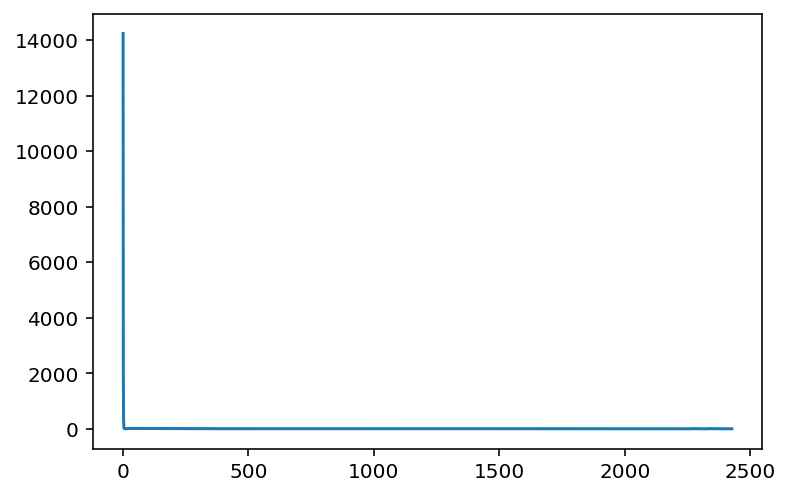

In [44]:
# Plot loss

plt.plot(losses)


In [45]:
mu, log_sigma = model(train)
train_loss = heteroskedastic_loss(train_target,mu, log_sigma)
train_loss

tensor(3.4095, device='cuda:0', grad_fn=<NegBackward0>)

In [46]:
mu, log_sigma = model(test)
test_loss = heteroskedastic_loss(test_target,mu, log_sigma)
test_loss

tensor(3.4313, device='cuda:0', grad_fn=<NegBackward0>)

In [47]:
loss = nn.MSELoss()
loss2 = loss(test_target, mu)
loss2/test_target.shape[0]

##transform variable

tensor(0.1169, device='cuda:0', grad_fn=<DivBackward0>)

In [61]:
valid = torch.tensor(X_valid.astype(np.float32)).to(device)
valid_target = torch.tensor(y_valid.values.astype(np.float32)).to(device)

NameError: name 'X_valid' is not defined

In [ ]:
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
import ray

import torch
import torch.nn as nn

class HeteroskedasticMLP_ray(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3):
        super(HeteroskedasticMLP_ray, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, 2)

        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        z = self.fc4(x)
        # Get mu and log_sigma from the last layer
        mu, log_sigma = z[:, 0], z[:, 1]
        return mu, log_sigma

In [ ]:
def heteroskedastic_loss(y, mu, log_sigma):
    sigma = torch.exp(log_sigma)
    ll = dist.Normal(mu.ravel(), sigma.ravel()).log_prob(y.ravel())
    return -ll.mean()

def training_loop(config):
    model = HeteroskedasticMLP_ray(4,config["l1"], config["l2"], config["l3"])
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'],weight_decay = 10)

    for epoch in range(1000):
        # Forward pass
        optimizer.zero_grad()
        mu, log_sigma = model(train)
        loss = heteroskedastic_loss(train_target,mu, log_sigma)
        # losses.append(loss.item())

        # Backward pass
        
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        mu, log_sigma = model(valid)
        loss = heteroskedastic_loss(valid_target,mu, log_sigma)
        return {"loss": loss.item(), "status": "ok"}


In [ ]:

ray.shutdown()

ray.init()
scheduler = ASHAScheduler()

config={
        "l1": tune.choice([4,8,16,32,64, 128, 256,512,1024]),
        "l2": tune.choice([4,8,16,32,64, 128, 256,512,1024]),
        "l3": tune.choice([4,8,16,32,64, 128, 256,512,1024]),
        "lr": tune.loguniform(3e-4, 1e-2)
    }

reporter = JupyterNotebookReporter(
    parameter_columns=["l1", "l2", "l3", "lr"],
    metric_columns=["loss", "training_iteration"])
tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(training_loop),
            resources={"cpu": 32, "gpu": 1}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=25,
        ),
        param_space=config,
    )
results = tuner.fit()

# analysis = tune.run(training_loop, resources_per_trial={"gpu": 1, "cpu" : 1},
#     ,
#     num_samples=2,
#     scheduler=scheduler,
#     progress_reporter=reporter)





2023-04-12 15:42:27,520	INFO tune.py:799 -- Total run time: 994.50 seconds (994.30 seconds for the tuning loop).


df

In [ ]:
df = results.get_dataframe()

In [ ]:
df

,loss,status,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,...,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,config/l1,config/l2,config/l3,config/lr,logdir
0,67.781395,ok,13.262736,False,NaN,NaN,1,36460_00000,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-26-13,...,10.0.62.229,13.262736,0,1,0.007354,128,8,4,0.000312,/home/agarwal.aditi/ray_results/training_loop_...
1,7.928380,ok,9.708946,False,NaN,NaN,1,36460_00001,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-26-23,...,10.0.62.229,9.708946,0,1,0.007354,64,16,4,0.003434,/home/agarwal.aditi/ray_results/training_loop_...
2,7.625905,ok,15.676835,False,NaN,NaN,1,36460_00002,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-26-39,...,10.0.62.229,15.676835,0,1,0.007354,4,64,128,0.000796,/home/agarwal.aditi/ray_results/training_loop_...
3,7.913624,ok,45.510166,True,NaN,NaN,1,36460_00003,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-27-24,...,10.0.62.229,45.510166,0,1,0.007354,256,16,1024,0.001156,/home/agarwal.aditi/ray_results/training_loop_...
4,7.645242,ok,45.587670,False,NaN,NaN,1,36460_00004,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-28-10,...,10.0.62.229,45.587670,0,1,0.007354,16,256,512,0.000667,/home/agarwal.aditi/ray_results/training_loop_...
5,7.929790,ok,12.767963,True,NaN,NaN,1,36460_00005,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-28-23,...,10.0.62.229,12.767963,0,1,0.007354,8,16,128,0.001777,/home/agarwal.aditi/ray_results/training_loop_...
6,10.183297,ok,10.034429,True,NaN,NaN,1,36460_00006,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-28-33,...,10.0.62.229,10.034429,0,1,0.007354,16,64,32,0.000735,/home/agarwal.aditi/ray_results/training_loop_...
7,8.099087,ok,121.088538,True,NaN,NaN,1,36460_00007,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-30-34,...,10.0.62.229,121.088538,0,1,0.007354,32,1024,512,0.002721,/home/agarwal.aditi/ray_results/training_loop_...
8,8.504457,ok,42.027369,True,NaN,NaN,1,36460_00008,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-31-16,...,10.0.62.229,42.027369,0,1,0.007354,64,4,1024,0.001602,/home/agarwal.aditi/ray_results/training_loop_...
9,7.917267,ok,58.241811,True,NaN,NaN,1,36460_00009,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-32-14,...,10.0.62.229,58.241811,0,1,0.007354,128,1024,8,0.000487,/home/agarwal.aditi/ray_results/training_loop_...


In [ ]:


# Sort the table by loss
df.sort_values(by="loss", inplace=True, ascending=True)

df

,loss,status,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,...,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,config/l1,config/l2,config/l3,config/lr,logdir
21,7.521893,ok,12.628594,False,NaN,NaN,1,36460_00021,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-37-30,...,10.0.62.229,12.628594,0,1,0.007354,64,64,32,0.001152,/home/agarwal.aditi/ray_results/training_loop_...
17,7.595755,ok,31.028212,False,NaN,NaN,1,36460_00017,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-35-47,...,10.0.62.229,31.028212,0,1,0.007354,32,256,256,0.000521,/home/agarwal.aditi/ray_results/training_loop_...
2,7.625905,ok,15.676835,False,NaN,NaN,1,36460_00002,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-26-39,...,10.0.62.229,15.676835,0,1,0.007354,4,64,128,0.000796,/home/agarwal.aditi/ray_results/training_loop_...
4,7.645242,ok,45.587670,False,NaN,NaN,1,36460_00004,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-28-10,...,10.0.62.229,45.587670,0,1,0.007354,16,256,512,0.000667,/home/agarwal.aditi/ray_results/training_loop_...
11,7.664794,ok,68.678085,False,NaN,NaN,1,36460_00011,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-33-36,...,10.0.62.229,68.678085,0,1,0.007354,64,1024,128,0.000438,/home/agarwal.aditi/ray_results/training_loop_...
16,7.764125,ok,57.984118,False,NaN,NaN,1,36460_00016,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-35-16,...,10.0.62.229,57.984118,0,1,0.007354,16,128,1024,0.000743,/home/agarwal.aditi/ray_results/training_loop_...
23,7.848362,ok,48.827360,True,NaN,NaN,1,36460_00023,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-41-46,...,10.0.62.229,48.827360,0,1,0.007354,8,1024,64,0.000686,/home/agarwal.aditi/ray_results/training_loop_...
13,7.871433,ok,10.832195,False,NaN,NaN,1,36460_00013,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-33-55,...,10.0.62.229,10.832195,0,1,0.007354,4,32,64,0.001279,/home/agarwal.aditi/ray_results/training_loop_...
22,7.890491,ok,207.388208,True,NaN,NaN,1,36460_00022,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-40-58,...,10.0.62.229,207.388208,0,1,0.007354,1024,1024,16,0.000378,/home/agarwal.aditi/ray_results/training_loop_...
10,7.895046,ok,12.787423,False,NaN,NaN,1,36460_00010,391ffa87a33942d1b8626af180e4926c,2023-04-12_15-32-27,...,10.0.62.229,12.787423,0,1,0.007354,64,8,64,0.001074,/home/agarwal.aditi/ray_results/training_loop_...


In [ ]:
df.to_csv('raytune.csv')

In [ ]:
64	64	32	0.001152

In [ ]:
class HeteroskedasticMLP_optim(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(HeteroskedasticMLP_optim, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 1)
        nn.Dropout(0.1)
        self.fc3= nn.Linear(1, 16)
        self.fc4 = nn.Linear(16, 256)
        nn.Dropout(0.2)
        self.fc5 = nn.Linear(256, 32)
        self.fc6 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        z = self.fc6(x)
        # Get mu and log_sigma from the last layer
        mu, log_sigma = z[:, 0], z[:, 1]
        return mu, log_sigma

In [ ]:
# Create model

model = HeteroskedasticMLP_optim(4, 100)

# Move model to device

model = model.to(device)

# Define loss function

def heteroskedastic_loss(y, mu, log_sigma):
    sigma = torch.exp(log_sigma)
    ll = dist.Normal(mu.ravel(), sigma.ravel()).log_prob(y.ravel())
    return -ll.mean()

In [ ]:
# Train model with Adam

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 0)
every_i = 10
outs= {}
losses = []

for epoch in range(3000):
    # Store model predictions every_i epochs
    if epoch % every_i == 0:
        
        with torch.no_grad():
            mu, log_sigma = model(train)
            outs[epoch] = {"mu":mu.cpu().numpy(),
                            "log_sigma":log_sigma.cpu().numpy()}

            # Print loss
            loss = heteroskedastic_loss(train_target, mu, log_sigma)
            print("Epoch: {}, Loss: {}".format(epoch, loss.item()))

    # Forward pass
    mu, log_sigma = model(train)
    loss = heteroskedastic_loss(train_target,mu, log_sigma)
    losses.append(loss.item())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0, Loss: 11006.2890625
Epoch: 10, Loss: 7.981164932250977
Epoch: 20, Loss: 14.028111457824707
Epoch: 30, Loss: 14.171401977539062
Epoch: 40, Loss: 8.72610092163086
Epoch: 50, Loss: 6.619391918182373
Epoch: 60, Loss: 6.1720099449157715
Epoch: 70, Loss: 6.220959663391113
Epoch: 80, Loss: 6.152171611785889
Epoch: 90, Loss: 6.078566074371338
Epoch: 100, Loss: 6.0552215576171875
Epoch: 110, Loss: 6.038563251495361
Epoch: 120, Loss: 6.018847942352295
Epoch: 130, Loss: 6.002584934234619
Epoch: 140, Loss: 5.985833168029785
Epoch: 150, Loss: 5.969952583312988
Epoch: 160, Loss: 5.954555034637451
Epoch: 170, Loss: 5.939940929412842
Epoch: 180, Loss: 5.926204204559326
Epoch: 190, Loss: 5.913490295410156
Epoch: 200, Loss: 5.901923656463623
Epoch: 210, Loss: 5.891592025756836
Epoch: 220, Loss: 5.8825507164001465
Epoch: 230, Loss: 5.874810218811035
Epoch: 240, Loss: 5.868332862854004
Epoch: 250, Loss: 5.863041400909424
Epoch: 260, Loss: 5.858822345733643
Epoch: 270, Loss: 5.855539321899414
Epo

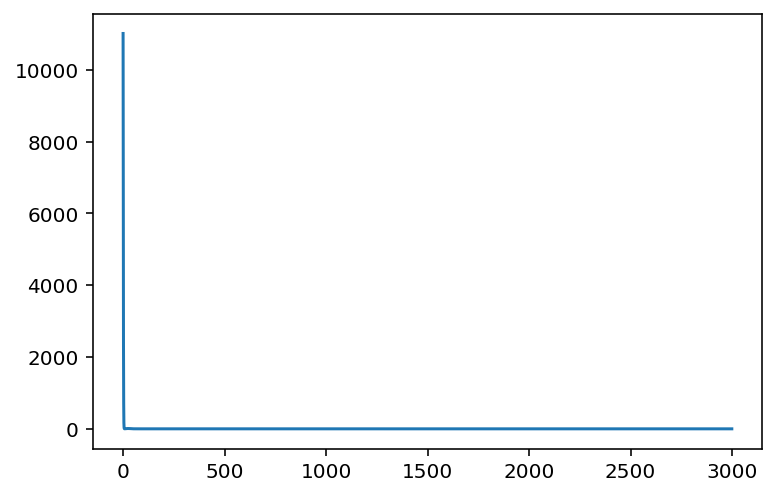

In [ ]:
plt.plot(losses)

In [ ]:
mu, log_sigma = model(train)
train_loss = heteroskedastic_loss(train_target,mu, log_sigma)
train_loss

tensor(5.8470, device='cuda:0', grad_fn=<NegBackward0>)

In [ ]:
mu, log_sigma = model(test)
test_loss = heteroskedastic_loss(test_target,mu, log_sigma)
test_loss

tensor(5.8496, device='cuda:0', grad_fn=<NegBackward0>)

In [ ]:
mu, log_sigma = model(valid)
valid_loss = heteroskedastic_loss(valid_target,mu, log_sigma)
valid_loss

NameError: name 'valid' is not defined

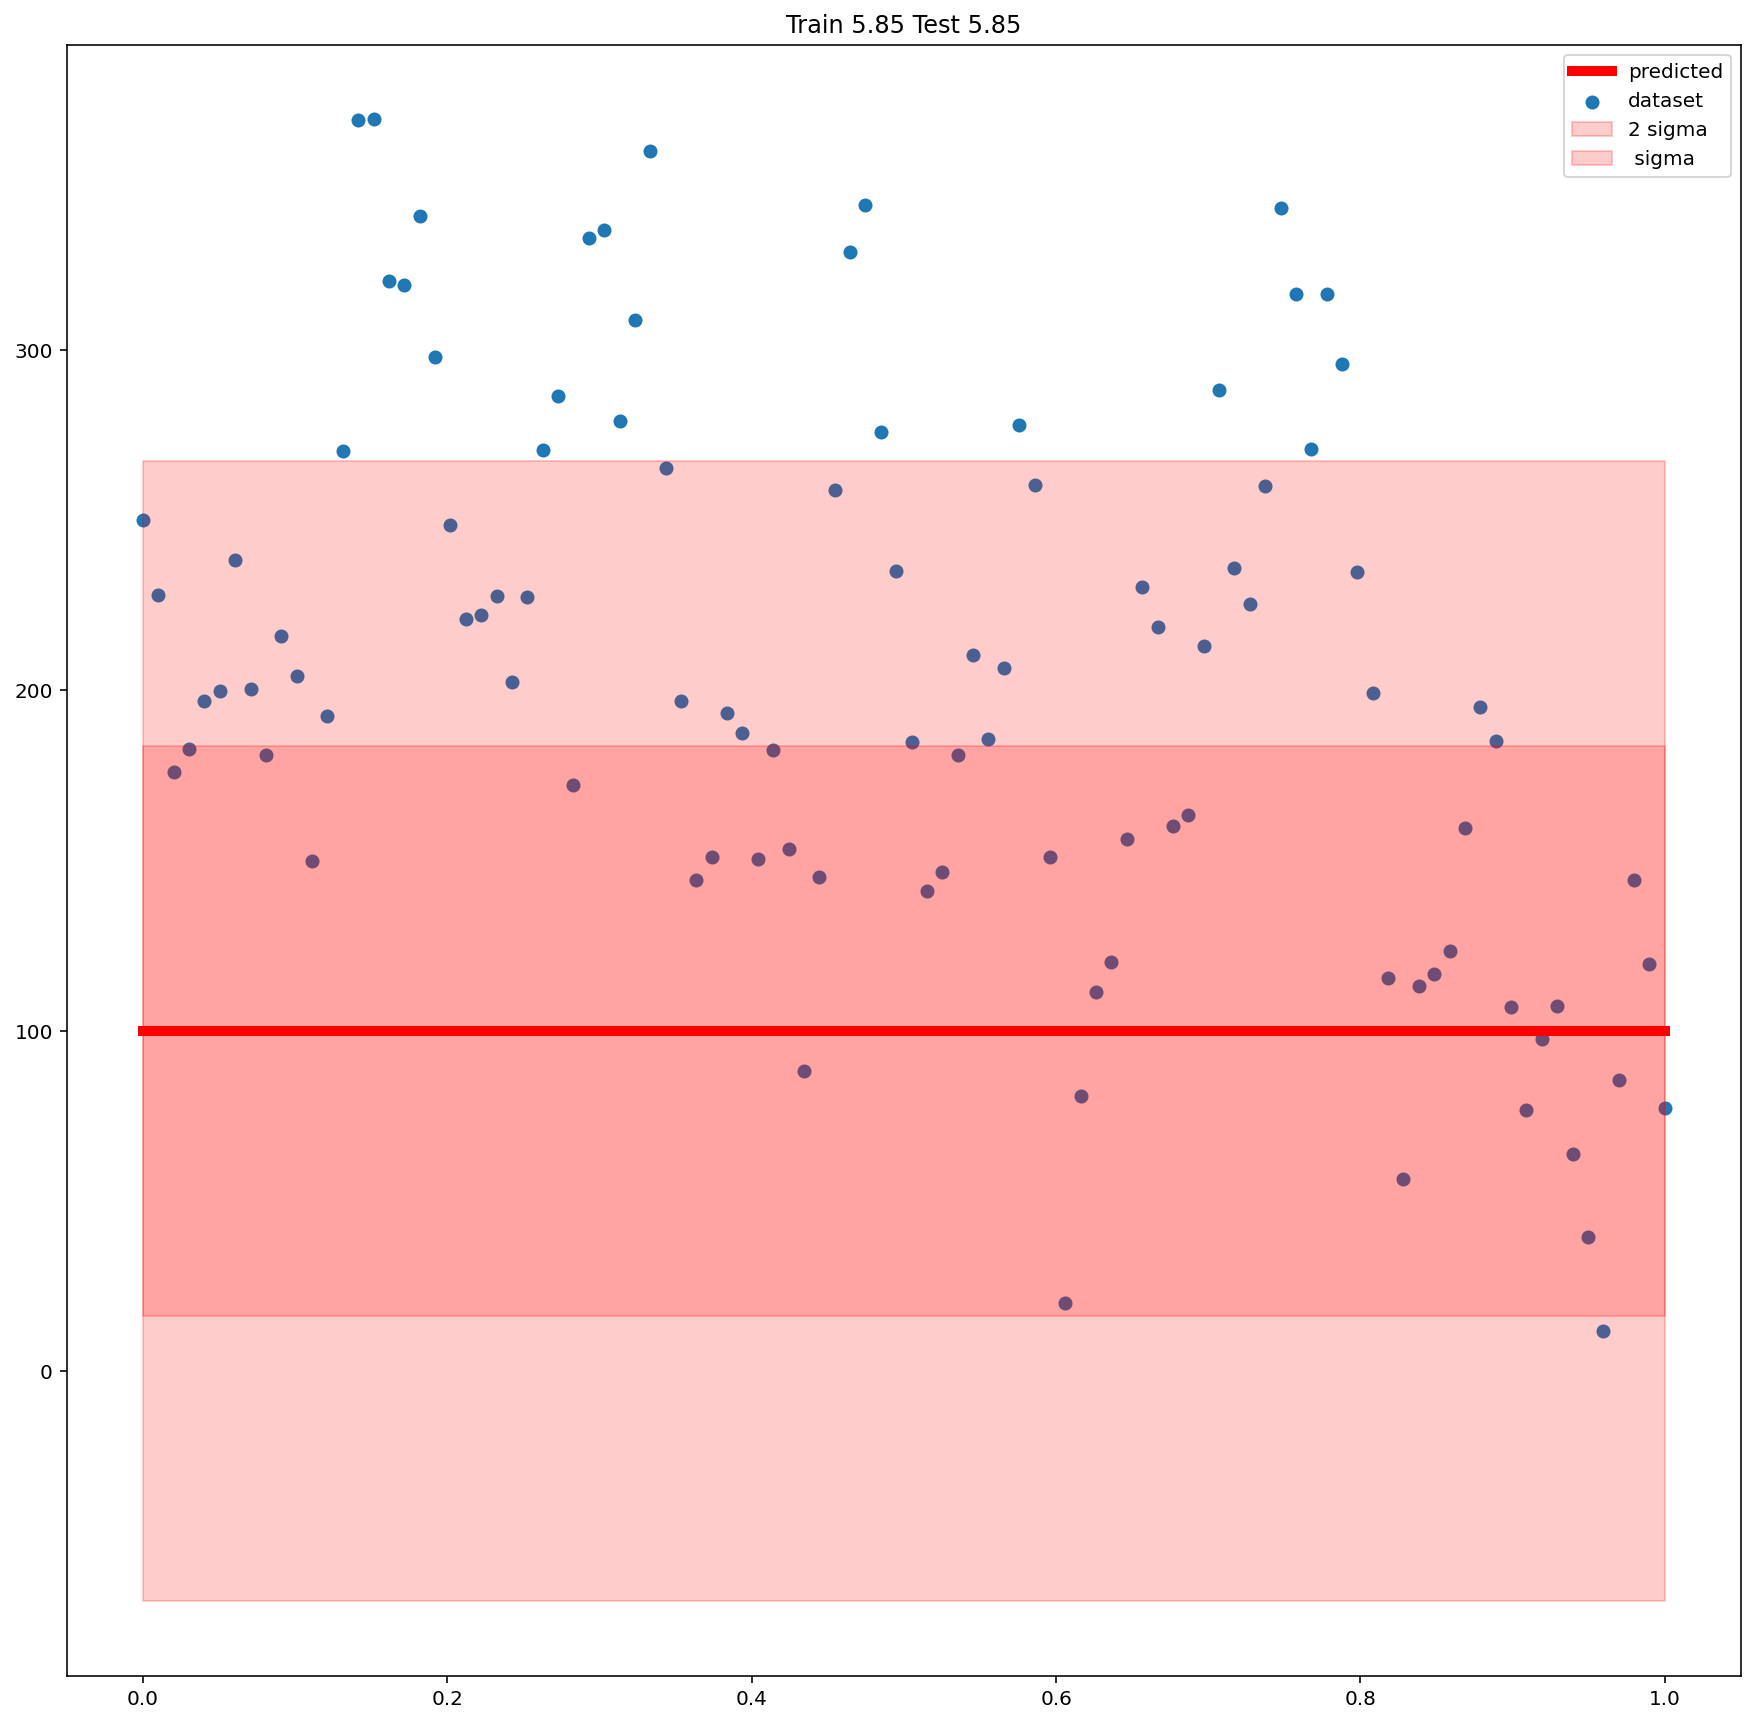

In [ ]:
with torch.no_grad():
    mu, log_sigma = model(train[0:100])
    sigma = torch.exp(log_sigma)
    fig = plt.figure(figsize = (15,15))
    plt.scatter(np.linspace(0,1,100), train_target.cpu().numpy()[0:100], label = 'dataset')
    plt.plot(np.linspace(0,1,100), mu.cpu().numpy(), 'r-', lw=5, label = 'predicted')
    plt.fill_between(np.linspace(0,1,100), mu.cpu().numpy() - 2*sigma.cpu().numpy(), mu.cpu().numpy() + 2*sigma.cpu().numpy(), color = 'r', alpha=0.2, label = '2 sigma')
    plt.fill_between(np.linspace(0,1,100), mu.cpu().numpy() - sigma.cpu().numpy(), mu.cpu().numpy() + sigma.cpu().numpy(), color = 'r' ,alpha=0.2, label = ' sigma')

    plt.title(f'Train {train_loss:.2f} Test {test_loss:.2f}')
    plt.legend()

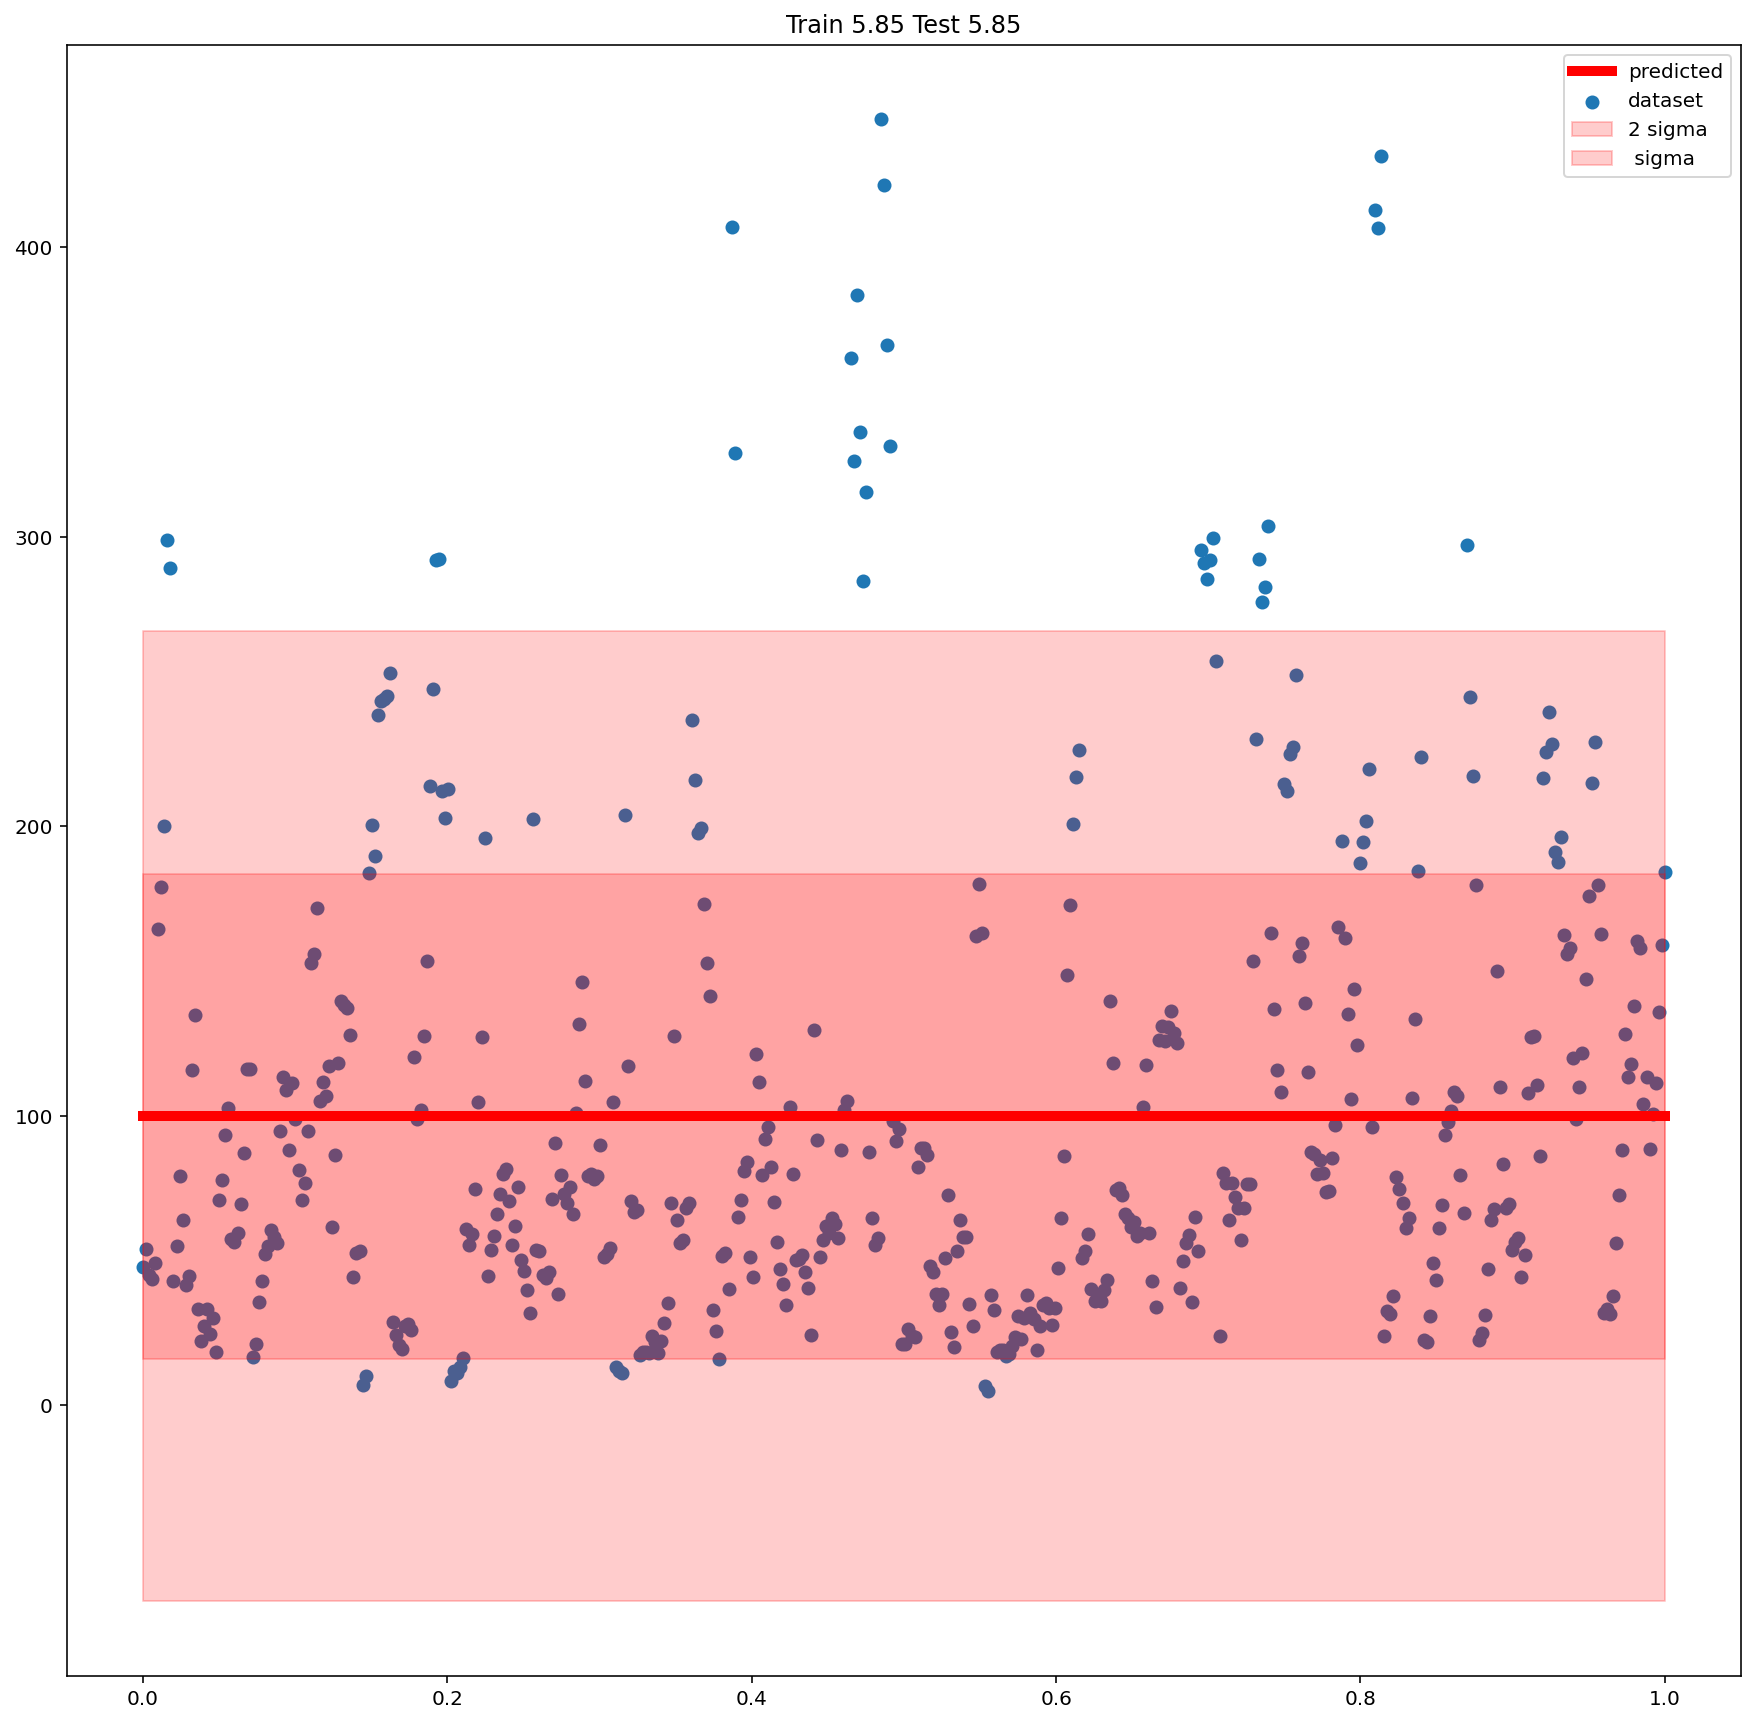

In [ ]:
with torch.no_grad():
    mu, log_sigma = model(test[0:500])
    sigma = torch.exp(log_sigma)
    fig = plt.figure(figsize = (15,15))
    plt.scatter(np.linspace(0,1,500), test_target.cpu().numpy()[0:500], label = 'dataset')
    plt.plot(np.linspace(0,1,500), mu.cpu().numpy(), 'r-', lw=5, label = 'predicted')
    plt.fill_between(np.linspace(0,1,500), mu.cpu().numpy() - 2*sigma.cpu().numpy(), mu.cpu().numpy() + 2*sigma.cpu().numpy(), color = 'r', alpha=0.2, label = '2 sigma')
    plt.fill_between(np.linspace(0,1,500), mu.cpu().numpy() - sigma.cpu().numpy(), mu.cpu().numpy() + sigma.cpu().numpy(), color = 'r' ,alpha=0.2, label = ' sigma')

    plt.title(f'Train {train_loss:.2f} Test {test_loss:.2f}')
    plt.legend()

In [ ]:
import seaborn as sns
import scipy.stats as st

In [ ]:
def plot_calibration(mean, sigma, Y, label, color, ax = None):
        if ax is None:
            fig, ax = plt.subplots()
        df = pd.DataFrame()
        df["mean"] = mean
        df["sigma"] = sigma
        df["Y"] = Y
        
        df["z"] = (df["Y"] - df["mean"]) / df["sigma"]
        df["perc"] = st.norm.cdf(df["z"])
        #use ppf, rechek
        k = np.arange(0, 1.1, 0.1)
        counts = []
        df2 = pd.DataFrame()
        df2["Interval"] = k
        df2["Ideal"] = k
        for i in range(0, 11):
            l = df[df["perc"] < 0.5 + i * 0.05]
            l = l[l["perc"] >= 0.5 - i * 0.05]
            counts.append(len(l) / len(df))
        df2["Counts"] = counts

        ax.plot(k, counts, color=color, label=label)
        print(counts)
        ax.scatter(k, counts, color=color,s=6)
        ax.scatter(k, k,color="green",s=6)
        ax.set_yticks(k)
        ax.set_xticks(k)
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        # ax.legend()
        ax.set_xlabel("decile")
        ax.set_ylabel("ratio of points")
        ax.plot(k, k, color="green")
        sns.despine()
        return df, df2

In [ ]:
sigma_test.shape

torch.Size([15004])

In [ ]:
mu_test.shape

torch.Size([15004])

In [ ]:
y_test

29777      47.75
29778      54.00
29779      45.00
29780      43.50
29781      49.00
           ...  
166277     78.75
166278     91.25
166279     99.75
166280    115.00
166281    120.50
Name: PM2.5, Length: 15004, dtype: float64

In [ ]:
df1

,mean,sigma,Y,z,perc
0,46.502934,32.631020,NaN,NaN,NaN
1,46.510052,32.615223,NaN,NaN,NaN
2,46.517170,32.599442,NaN,NaN,NaN
3,46.524288,32.583660,NaN,NaN,NaN
4,46.531406,32.567905,NaN,NaN,NaN
...,...,...,...,...,...
14999,113.417496,66.569595,NaN,NaN,NaN
15000,113.451340,66.564224,NaN,NaN,NaN
15001,113.485199,66.558990,NaN,NaN,NaN
15002,113.519058,66.553719,NaN,NaN,NaN


In [ ]:
y_test.reset_index(drop=True, inplace=True)

[0.0, 0.09678064387122576, 0.1895620875824835, 0.2835432913417317, 0.3774578417649803, 0.4735719522762114, 0.5800839832033593, 0.6885289608744918, 0.8009731387055922, 0.9192161567686463, 1.0]
[0.0, 0.09141750764366255, 0.18359067577638022, 0.27719158953357986, 0.3717884429215158, 0.47269175320198076, 0.5796612412332937, 0.6909975414916808, 0.8058440066024529, 0.9206521663428122, 1.0]


Text(0.5, 1.0, 'Train 3.07 Test 3.08')

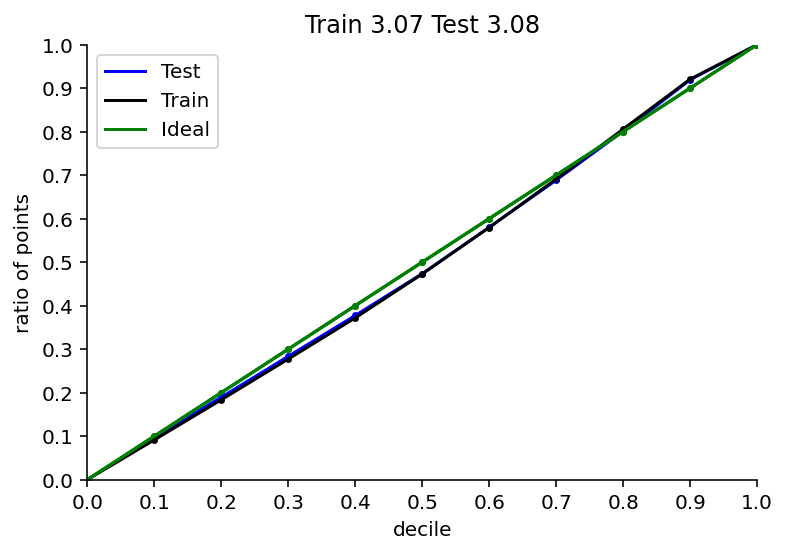

In [47]:
fig, ax = plt.subplots(1)
mu_test, log_sigma_test = model(test)
mu_train, log_sigma_train = model(train)
sigma_test = torch.exp(log_sigma_test)
sigma_train = torch.exp(log_sigma_train)
df1, df_test = plot_calibration(
    mu_test.detach().cpu().numpy(), sigma_test.detach().cpu().numpy(), y_test.reset_index(drop=True),"Test", "blue", ax
)
_, df_train = plot_calibration(
    mu_train.detach().cpu().numpy(), sigma_train.detach().cpu().numpy(), y_train.reset_index(drop=True), "Train", "black", ax
)
k = np.arange(0, 1.1, 0.1)
ax.plot(k,k,label='Ideal',color='Green')
ax.legend()
ax.set_title(f"Train {train_loss:.2f} Test {test_loss:.2f}")


In [112]:
# Train model with Adam
# Create model

model = HeteroskedasticMLP_optim(4, 100)

# Move model to device

model = model.to(device)

# Define loss function

def heteroskedastic_loss(y, mu, log_sigma):
    sigma = torch.exp(log_sigma)
    ll = dist.Normal(mu.ravel(), sigma.ravel()).log_prob(y.ravel())
    return -ll.mean()
optimizer = optim.Adam(model.parameters(), lr=0.01)
every_i = 10
outs= {}
losses = []

for epoch in range(3000):
    # Store model predictions every_i epochs
    if epoch % every_i == 0:
        
        with torch.no_grad():
            mu, log_sigma = model(train)
            outs[epoch] = {"mu":mu.cpu().numpy(),
                            "log_sigma":log_sigma.cpu().numpy()}

            # Print loss
            loss = heteroskedastic_loss(train_target, mu, log_sigma)
            loss_2 = nn.MSELoss()
            loss2 = loss_2(mu, train_target)
            print("Epoch: {}, Loss_ll: {}, Loss_MSE: {}".format(epoch, loss.item(), loss2.item()))

    # Forward pass
    mu, log_sigma = model(train)
    loss = heteroskedastic_loss(train_target,mu, log_sigma)
    loss_2 = nn.MSELoss()
    loss2 = loss_2(mu,train_target)
    losses.append(loss.item())

    # Backward pass
    optimizer.zero_grad()
    if(epoch>=100 and epoch <=1500):
        loss2.backward(retain_graph= True)
    else:
        loss.backward()
    optimizer.step()

Epoch: 0, Loss_ll: 11330.123046875, Loss_MSE: 16935.130859375
Epoch: 10, Loss_ll: 10.083998680114746, Loss_MSE: 16508.0078125
Epoch: 20, Loss_ll: 8.561872482299805, Loss_MSE: 16116.11328125
Epoch: 30, Loss_ll: 9.84037971496582, Loss_MSE: 15926.828125
Epoch: 40, Loss_ll: 10.363761901855469, Loss_MSE: 15848.435546875
Epoch: 50, Loss_ll: 10.527216911315918, Loss_MSE: 15819.8037109375
Epoch: 60, Loss_ll: 10.538348197937012, Loss_MSE: 15811.8828125
Epoch: 70, Loss_ll: 10.486260414123535, Loss_MSE: 15812.330078125
Epoch: 80, Loss_ll: 10.4071683883667, Loss_MSE: 15816.177734375
Epoch: 90, Loss_ll: 10.315563201904297, Loss_MSE: 15821.466796875
Epoch: 100, Loss_ll: 10.217330932617188, Loss_MSE: 15827.43359375
Epoch: 110, Loss_ll: 14.054709434509277, Loss_MSE: 13433.2939453125
Epoch: 120, Loss_ll: 29.68570899963379, Loss_MSE: 7386.02783203125
Epoch: 130, Loss_ll: 44.45882797241211, Loss_MSE: 7112.1181640625
Epoch: 140, Loss_ll: 34.792152404785156, Loss_MSE: 6272.6611328125
Epoch: 150, Loss_ll: 3

In [113]:
mu, log_sigma = model(train)
train_loss = heteroskedastic_loss(train_target,mu, log_sigma)
train_loss

tensor(5.7264, device='cuda:0', grad_fn=<NegBackward0>)

In [114]:
mu, log_sigma = model(test)
test_loss = heteroskedastic_loss(test_target,mu, log_sigma)
test_loss

tensor(5.7534, device='cuda:0', grad_fn=<NegBackward0>)

In [98]:
mu, log_sigma = model(valid)
valid_loss = heteroskedastic_loss(valid_target,mu, log_sigma)
valid_loss

NameError: name 'valid' is not defined

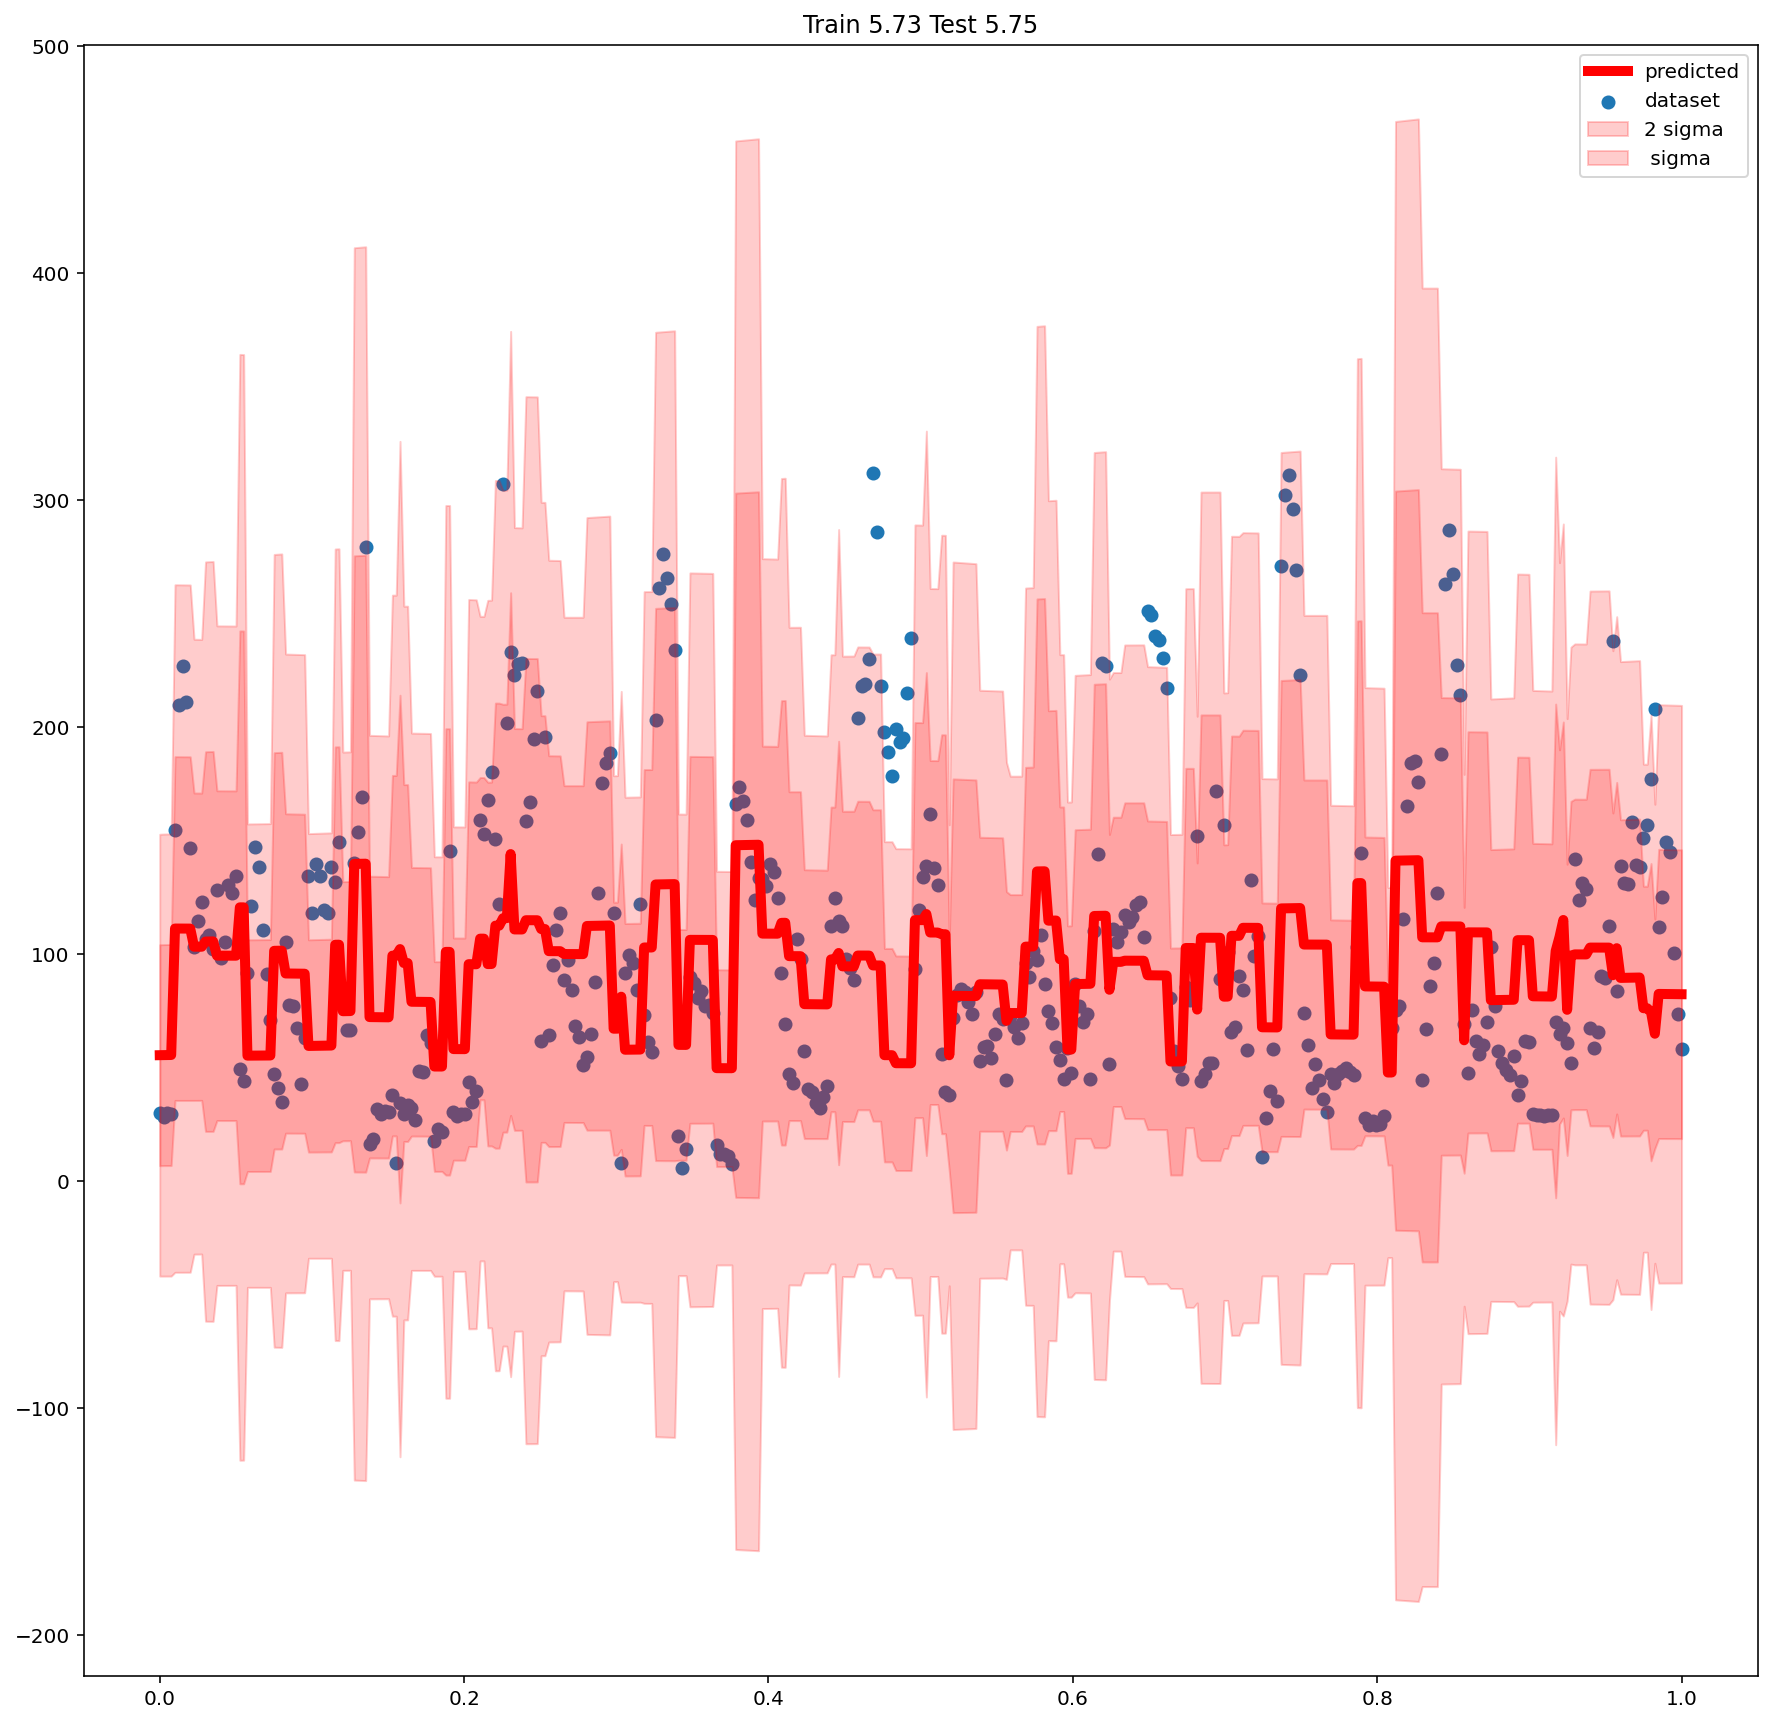

In [121]:
with torch.no_grad():
    mu, log_sigma = model(test[:400])
    sigma = torch.exp(log_sigma)
    fig = plt.figure(figsize = (15,15))
    plt.scatter(np.linspace(0,1,400), test_target.cpu().numpy()[:400], label = 'dataset')
    plt.plot(np.linspace(0,1,400), mu.cpu().numpy(), 'r-', lw=5, label = 'predicted')
    plt.fill_between(np.linspace(0,1,400), mu.cpu().numpy() - 2*sigma.cpu().numpy(), mu.cpu().numpy() + 2*sigma.cpu().numpy(), color = 'r', alpha=0.2, label = '2 sigma')
    plt.fill_between(np.linspace(0,1,400), mu.cpu().numpy() - sigma.cpu().numpy(), mu.cpu().numpy() + sigma.cpu().numpy(), color = 'r' ,alpha=0.2, label = ' sigma')

    plt.title(f'Train {train_loss:.2f} Test {test_loss:.2f}')
    plt.legend()

[0.0, 0.0037997466835544298, 0.007932804479701353, 0.011999200053329778, 0.01826544897006866, 0.024398373441770548, 0.031131257916138924, 0.037997466835544294, 0.04179721351909873, 0.04386374241717219, 0.0485967602159856]
[0.0, 0.08448576538149666, 0.17129675912041203, 0.2618325613427083, 0.36120645287895115, 0.4696183737471351, 0.5872090224784416, 0.6964614319407881, 0.761201269248855, 0.7978236158781995, 0.9000485039673283]


Text(0.5, 1.0, 'Train 5.73 Test 5.75')

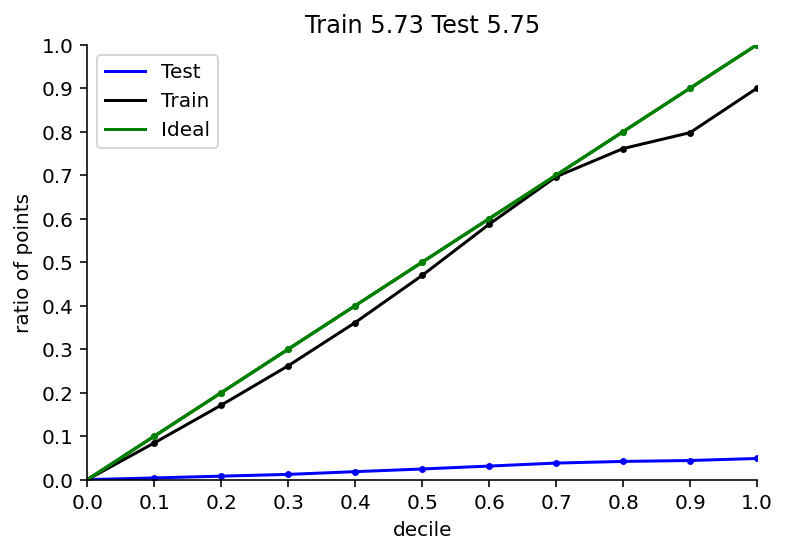

In [116]:
fig, ax = plt.subplots(1)
mu_test, log_sigma_test = model(test)
mu_train, log_sigma_train = model(train)
sigma_test = torch.exp(log_sigma_test)
sigma_train = torch.exp(log_sigma_train)
_, df_test = plot_calibration(
    mu_test.detach().cpu().numpy(), sigma_test.detach().cpu().numpy(), y_test,"Test", "blue", ax
)
_, df_train = plot_calibration(
    mu_train.detach().cpu().numpy(), sigma_train.detach().cpu().numpy(), y_train, "Train", "black", ax
)
k = np.arange(0, 1.1, 0.1)
ax.plot(k,k,label='Ideal',color='Green')
ax.legend()
ax.set_title(f"Train {train_loss:.2f} Test {test_loss:.2f}")


In [7]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

xg_boost = ensemble.GradientBoostingRegressor(n_estimators= 500,
    max_depth= 4)
xg_boost.fit(X_train,y_train)
y_pred = xg_boost.predict(X_test)
mean_squared_error(y_test,y_pred)


1751.5894247010958

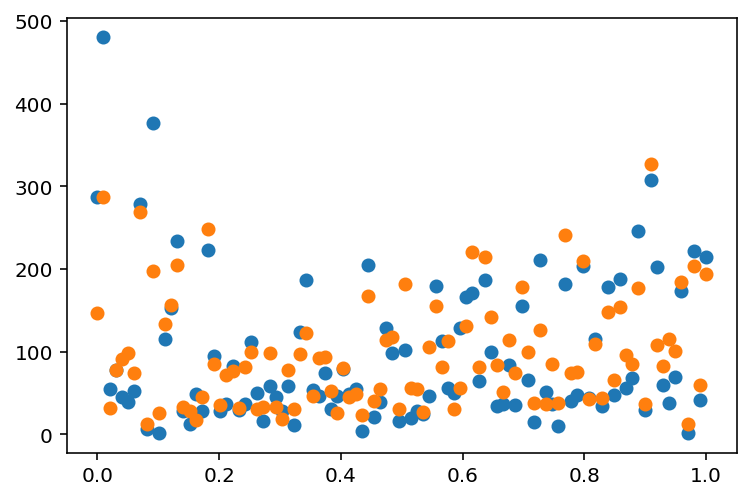

In [13]:
import numpy as np
plt.scatter(np.linspace(0,1,100), y_test[:100], label = 'dataset')
plt.scatter(np.linspace(0,1,100), y_pred[:100], label = 'predicted')


In [ ]:
##compare models, same splits, uncertainity estimate(calibration)(Try to improve(conformal predictions))
#Look at the Fourrier feautres
